## Grouped Query Attention From Scratch

In GQA the Query heads are divide into groups, where each group share a single Key & Value head.


**How it Works**
- **Grouping** Queries are partitioned into *G* groups. Each group shares the same computed Keys and Values.
- **Shared Computation** For each group, the Key and Value projections are shared, reducing the number of key/value computations and memory usage.

In [2]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np

In [3]:
class MHSA(nn.Module):
    def __init__(self, D_model = 512, head_dim = 64, causal = True):
        super().__init__()
        self.D_model = D_model
        self.head_dim = head_dim
        
        assert D_model % head_dim ==0, "Dimension of model should be a multiple of head_dim"
        self.num_heads = D_model // head_dim
        self.causal = causal
        
        self.wq = nn.Linear(D_model, D_model)
        self.wk = nn.Linear(D_model, D_model)
        self.wv = nn.Linear(D_model, D_model)
        self.wo = nn.Linear(D_model, D_model)
        
    def forward(self, x):
        B, S, D = x.shape
        q, k, v = self.wq(x), self.wk(x), self.wv(x)
        
        q = q.reshape(B, self.num_heads, S, self.head_dim)
        k = k.reshape(B, self.num_heads, S, self.head_dim)
        v = v.reshape(B, self.num_heads, S, self.head_dim)
        
        denominator = torch.sqrt(torch.tensor(self.head_dim))
        attn_weight = torch.einsum('bnij, bnkj->bnik', q, k)
        attn_weight = attn_weight / denominator
        
        attn_score = F.softmax(attn_weight, dim = -1)
        
        if self.causal:
            mask = torch.triu(torch.ones_like(attn_score), diagonal=1).bool()
            attn_score = attn_score.masked_fill(mask, float('-inf'))
            
        out = torch.einsum('bnik,bnjd->bnid', attn_score, v)
        out = out.reshape(B, S, -1)
        return self.wo(out)

B, S, D = 8 ,512, 768
attn = MHSA(D_model=D)
x = torch.randn(B, S, D)
attn(x).shape
        

torch.Size([8, 512, 768])

In [4]:
class GQA(nn.Module):
    def __init__(self, D_model = 512, head_dim = 64, causal = True, group_size = 4):
        super().__init__()
        self.D_model = D_model
        self.head_dim = head_dim
        self.causal = causal
        self.group_size = group_size
        
        assert D_model % head_dim == 0, "Error!!!!!!"
        self.num_query_heads = D_model // head_dim
        self.num_kv_heads = self.num_query_heads // self.group_size
        self.causal = causal
        
        self.D_kv = self.num_kv_heads * self.head_dim
        
        self.wq = nn.Linear(D_model, D_model)
        self.wk = nn.Linear(D_model, self.D_kv)
        self.wv = nn.Linear(D_model, self.D_kv)
        self.wo = nn.Linear(D_model, D_model)
        
    def forward(self, x):
        B, S, D = x.shape
        
        #Get the Q,K,V matrices
        Q = self.wq(x)
        K = self.wk(x)
        V = self.wv(x)
        
        #Reshape the Matrices so that all 3 contains Heads num and Heads Dim
        Q = Q.reshape(B, self.num_query_heads, S, self.head_dim)
        K = K.reshape(B, self.num_kv_heads, S, self.head_dim)
        V = V.reshape(B, self.num_kv_heads, S, self.head_dim)
        
        #Reshape K,V  to match Q by interleaving
        K = torch.repeat_interleave(K, self.group_size, dim = 1)
        V = torch.repeat_interleave(V, self.group_size, dim = 1)
        
        #Compute the Scaled Dot-Product Attention
        denominator = torch.sqrt(torch.tensor(self.head_dim, dtype=Q.dtype))
        attn_weights = torch.einsum('bnij, bnkj->bnik', Q, K) / denominator
        
        #Apply Causal Mask
        if self.causal:
            mask = torch.triu(torch.ones_like(attn_weights), diagonal=1).bool()
            attn_weights = attn_weights.masked_fill(mask, float('-inf'))
        
        #Compute the Attention Scores
        attn_scores = F.softmax(attn_weights, dim = -1)
        out = torch.einsum('bnij,bnjd->bnid', attn_scores, V)
        out = out.reshape(B, S, -1)
        return self.wo(out)


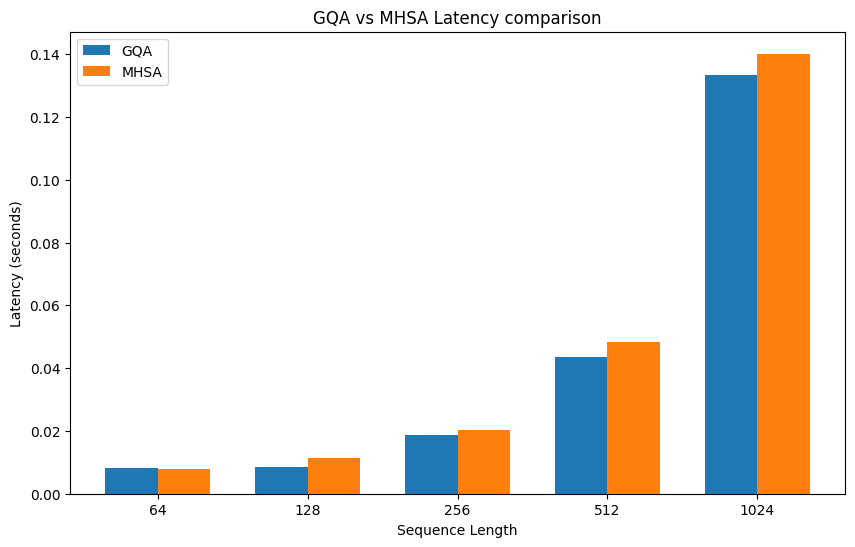

In [6]:
import matplotlib.pyplot as plt
import time

seq_lengths = [64,128,256,512,1024]
B, D = 1, 1024

gqa_times = []
mhsa_times = []

for S in seq_lengths:
    x = torch.randn(B, S, D)
    
    attn_gqa = GQA(D_model=D)
    
    for _ in range(5):
        _ = attn_gqa(x)
        
    start = time.perf_counter()
    for _ in range(10):
        _ = attn_gqa(x)
    gqa_times.append((time.perf_counter() - start) / 10)
    
    attn_mhsa = MHSA(D_model=D)
    
    for _ in range(5):
        _ = attn_mhsa(x)
    
    start = time.perf_counter()
    for _ in range(10):
        _ = attn_mhsa(x)
    mhsa_times.append((time.perf_counter() - start) / 10)
    
x = np.arange(len(seq_lengths))
width = 0.35

fig, ax = plt.subplots(figsize = (10,6))
ax.bar(x - width/2, gqa_times, width, label='GQA')
ax.bar(x + width/2, mhsa_times, width, label='MHSA')

ax.set_ylabel('Latency (seconds)')
ax.set_xlabel('Sequence Length')
ax.set_title('GQA vs MHSA Latency comparison')
ax.set_xticks(x)
ax.set_xticklabels(seq_lengths)
ax.legend()

plt.show() 

You can see how for longer seq_lengths **GQA** outperforms **MHSA**
